In [47]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.model_selection import train_test_split

In [48]:
# 데이터셋 인스턴스 생성

data = pd.read_csv('C:/Users/ghom9/Downloads/diabetes.csv')  # CSV 파일 경로
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [49]:
print(data.isna().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [50]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [51]:
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [53]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [55]:
data_array = np.hstack((X, y.reshape(-1, 1)))
data_array.shape

(768, 9)

In [58]:
# Split sequences function
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Apply sequence transformation
n_steps = 5
X, y = split_sequences(data_array, n_steps)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((611, 5, 8), (153, 5, 8), (611,), (153,))

In [39]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([611, 5, 8]),
 torch.Size([153, 5, 8]),
 torch.Size([611]),
 torch.Size([153]))

In [41]:
# Define the 1D CNN model
class diabetesCNN(nn.Module):
    def __init__(self):
        super(diabetesCNN, self).__init__()
        self.conv1 = nn.Conv1d(8, 16, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 5, 64)  
        self.fc2 = nn.Linear(64, 1)  
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
# Initialize the model
model = diabetesCNN()
summary(model, input_size=(8,5)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]             400
            Conv1d-2                [-1, 32, 5]           1,568
            Linear-3                   [-1, 64]          10,304
            Linear-4                    [-1, 1]              65
Total params: 12,337
Trainable params: 12,337
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [42]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
# 학습 변수 초기화
train_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # 현재 input shape (batch, n_steps, feature) -> CNN (batch, channels, sequence_length)
        inputs = inputs.permute(0, 2, 1)  # → (batch, 8, 5)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # outputs shape: (batch, 1)
        # BCEWithLogitsLoss용 
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    avg_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(avg_loss)
    
    # 평가 단계
    model.eval()
    correct = 0
    total = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.permute(0, 2, 1)
        outputs = model(inputs) 
        # sigmoid를 사용 0과 1로 분류
        preds = (torch.sigmoid(outputs) >= 0.5).int()
        total += labels.size(0)
        correct += (preds.squeeze(1) == labels).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6679, Accuracy: 62.75%
Epoch 2/20, Loss: 0.6304, Accuracy: 62.75%
Epoch 3/20, Loss: 0.6066, Accuracy: 62.75%
Epoch 4/20, Loss: 0.5674, Accuracy: 67.97%
Epoch 5/20, Loss: 0.5180, Accuracy: 72.55%
Epoch 6/20, Loss: 0.4772, Accuracy: 73.20%
Epoch 7/20, Loss: 0.4559, Accuracy: 73.86%
Epoch 8/20, Loss: 0.4342, Accuracy: 74.51%
Epoch 9/20, Loss: 0.4194, Accuracy: 73.86%
Epoch 10/20, Loss: 0.4026, Accuracy: 72.55%
Epoch 11/20, Loss: 0.3949, Accuracy: 72.55%
Epoch 12/20, Loss: 0.3816, Accuracy: 71.90%
Epoch 13/20, Loss: 0.3720, Accuracy: 73.20%
Epoch 14/20, Loss: 0.3608, Accuracy: 70.59%
Epoch 15/20, Loss: 0.3440, Accuracy: 71.24%
Epoch 16/20, Loss: 0.3352, Accuracy: 71.24%
Epoch 17/20, Loss: 0.3192, Accuracy: 69.28%
Epoch 18/20, Loss: 0.3092, Accuracy: 69.28%
Epoch 19/20, Loss: 0.3099, Accuracy: 69.28%
Epoch 20/20, Loss: 0.2821, Accuracy: 71.90%
Training complete.


In [44]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.permute(0, 2, 1)  # (batch, 8, 5)
        outputs = model(inputs)
        # 예측: sigmoid -> threshold (0.5)
        preds = (torch.sigmoid(outputs) >= 0.5).int()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions).flatten()

conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Confusion Matrix:
[[78 18]
 [25 32]]
F1 Score: 0.71
Precision: 0.71
Recall: 0.72


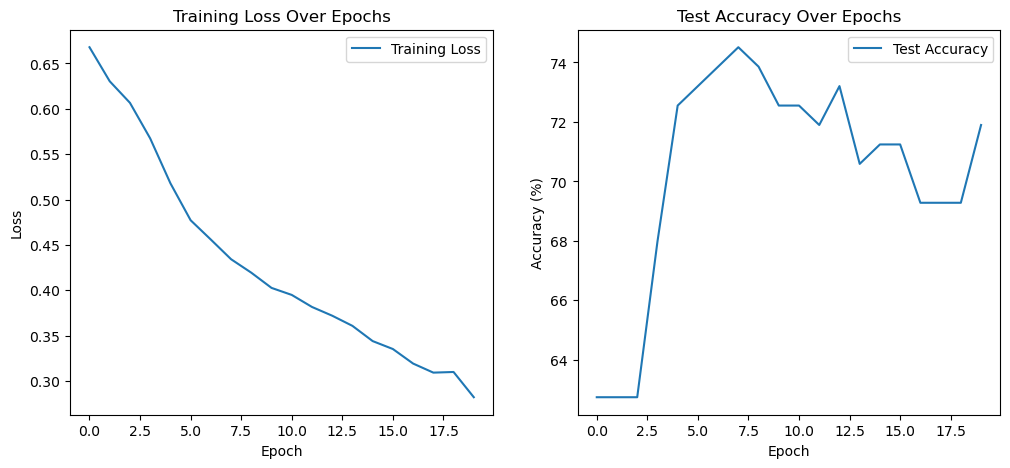

In [45]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()